#Predicción Fluctuaciones de divisas

En esta sección, hemos importado todas las bibliotecas esenciales que serán necesarias para el análisis y modelado de series temporales de las monedas.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Cargar el dataset
data = pd.read_csv('currency_prices.csv')
columns = data.columns
columns = data.columns.tolist()
columns.remove('Date')

all_predictions = pd.DataFrame()

# Mostrar las primeras filas del dataset
data.head()

Date   BTC-USD  CNYUSD=X  EURUSD=X     GC=F
0  2016-01-01  0.000000   0.00000  0.000000  0.00000
1  2016-01-02 -0.002063   0.00000  0.000000  0.00000
2  2016-01-03 -0.007907   0.00000  0.000000  0.00000
3  2016-01-04  0.007163   0.00000 -0.000467  0.00000
4  2016-01-05 -0.002611  -0.00639 -0.002436  0.00307

Los datos cargados contienen información sobre diferentes monedas a lo largo del tiempo. Es crucial inspeccionar los primeros registros para tener una idea preliminar de la estructura y el contenido del conjunto de datos.

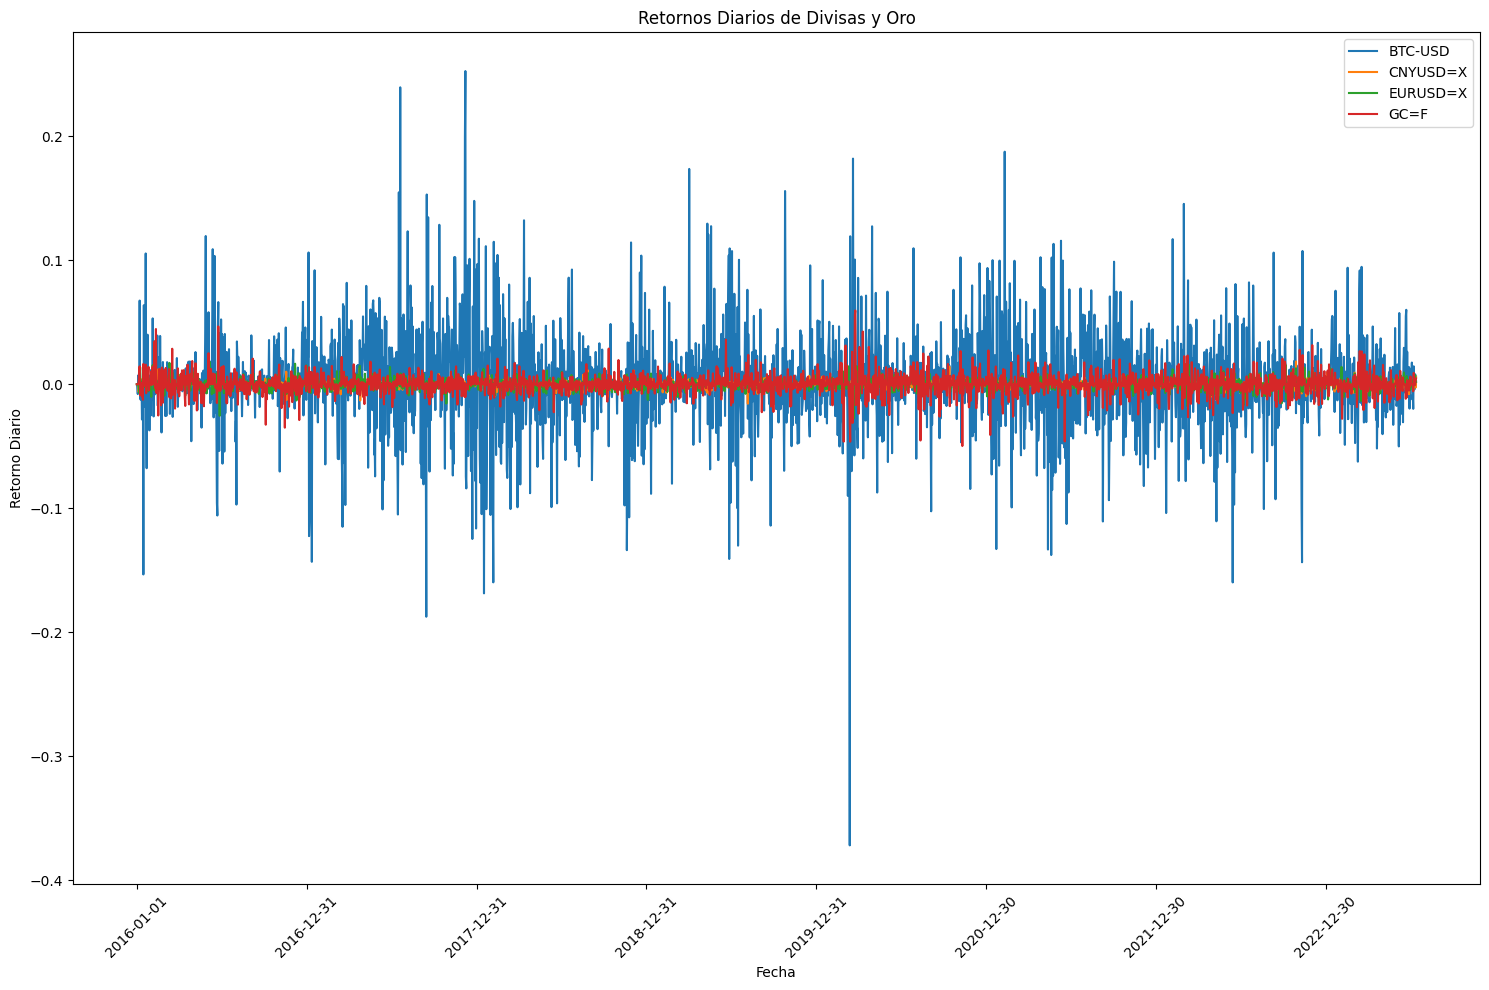

(           BTC-USD     CNYUSD=X     EURUSD=X         GC=F
 count  2750.000000  2750.000000  2750.000000  2750.000000
 mean      0.002278    -0.000035     0.000013     0.000244
 std       0.038022     0.002419     0.003950     0.007711
 min      -0.371695    -0.015674    -0.027752    -0.049787
 25%      -0.013155    -0.000671    -0.001537    -0.001861
 50%       0.001692     0.000000     0.000000     0.000000
 75%       0.017537     0.000628     0.001396     0.002772
 max       0.252472     0.018391     0.018378     0.059477,
            BTC-USD  CNYUSD=X  EURUSD=X      GC=F
 BTC-USD   1.000000 -0.029648 -0.001699  0.095187
 CNYUSD=X -0.029648  1.000000  0.361364  0.021976
 EURUSD=X -0.001699  0.361364  1.000000  0.068244
 GC=F      0.095187  0.021976  0.068244  1.000000)

In [ ]:
# Resumen estadístico
summary_stats = data.describe()

# Gráficos de series temporales
plt.figure(figsize=(15, 10))

# Plotting each currency and gold
for column in data.columns[1:]:
    plt.plot(data['Date'], data[column], label=column)

plt.title('Retornos Diarios de Divisas y Oro')
plt.xlabel('Fecha')
plt.ylabel('Retorno Diario')
plt.legend()
plt.xticks(data['Date'][::365], rotation=45)  # Displaying one tick per year for clarity
plt.tight_layout()
plt.show()

# Matriz de correlación
correlation_matrix = data.iloc[:, 1:].corr()

summary_stats, correlation_matrix


**Resumen Estadístico**:

* El BTC (Bitcoin) tiene el mayor retorno diario promedio, pero también tiene la mayor desviación estándar, lo que indica una mayor volatilidad en comparación con las otras divisas y el oro.
* El CNY (Yuan chino) y el EUR (Euro) tienen retornos diarios promedio cercanos a cero.
* El oro (GC=F) tiene un retorno diario promedio positivo pero pequeño.

**Gráficos de Series Temporales:**

* El Bitcoin muestra una tendencia clara de incremento a lo largo del tiempo, aunque con alta volatilidad.
* Las otras divisas y el oro parecen fluctuar alrededor de un retorno de cero, aunque hay ciertos periodos con movimientos más significativos.

**Matriz de Correlación:**

* El Bitcoin tiene una correlación positiva, aunque débil, con el oro. Esto podría indicar que en ciertas circunstancias, cuando el Bitcoin sube, el oro también podría subir (y viceversa).
* El Yuan chino (CNY) y el Euro (EUR) tienen una correlación positiva moderada entre ellos, lo que indica que tienden a moverse en la misma dirección.
* El oro tiene correlaciones positivas débiles con todas las divisas, pero estas correlaciones no son muy fuertes.

#Modelo ARIMA

In [ ]:
# Función para realizar la prueba de Dickey-Fuller aumentada
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return result[1]  # p-value

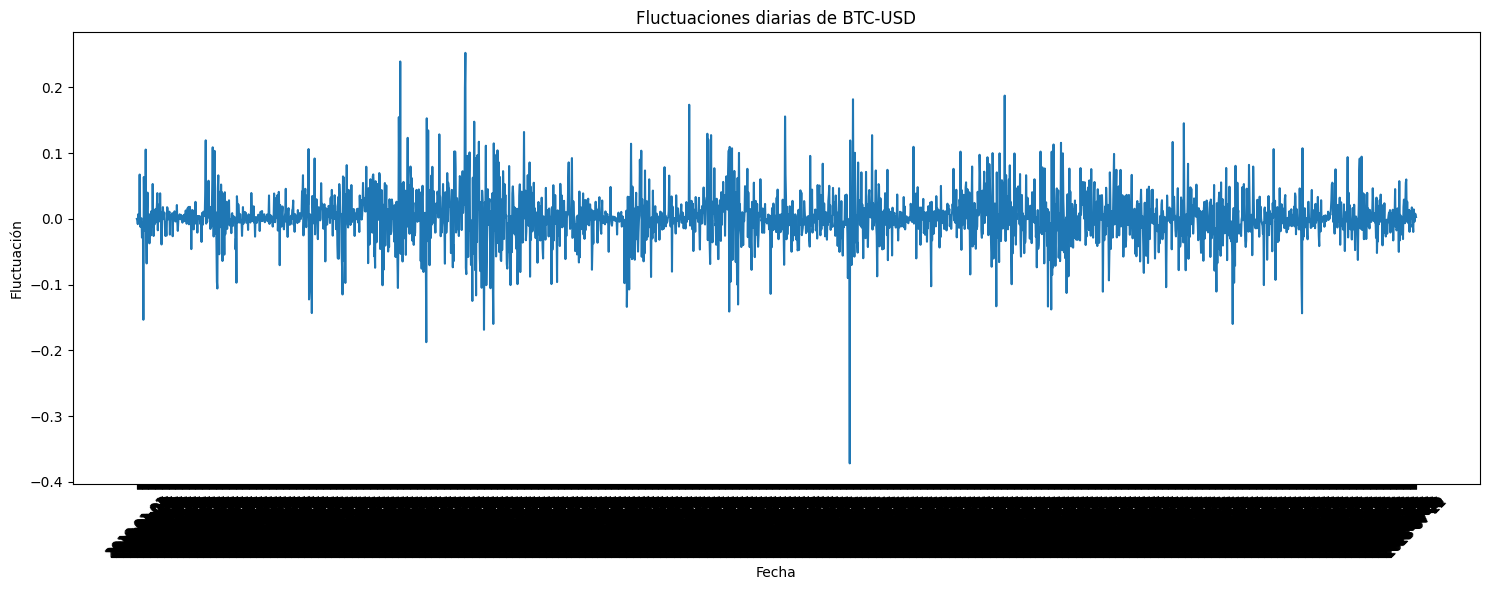

In [ ]:
# Graficar la serie temporal de BTC-USD
plt.figure(figsize=(15, 6))
plt.plot(data['Date'], data['BTC-USD'])
plt.title('Fluctuaciones diarias de BTC-USD')
plt.xlabel('Fecha')
plt.ylabel('Fluctuación')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Para una mejor visualización voy a acotar y mostrar el último año.

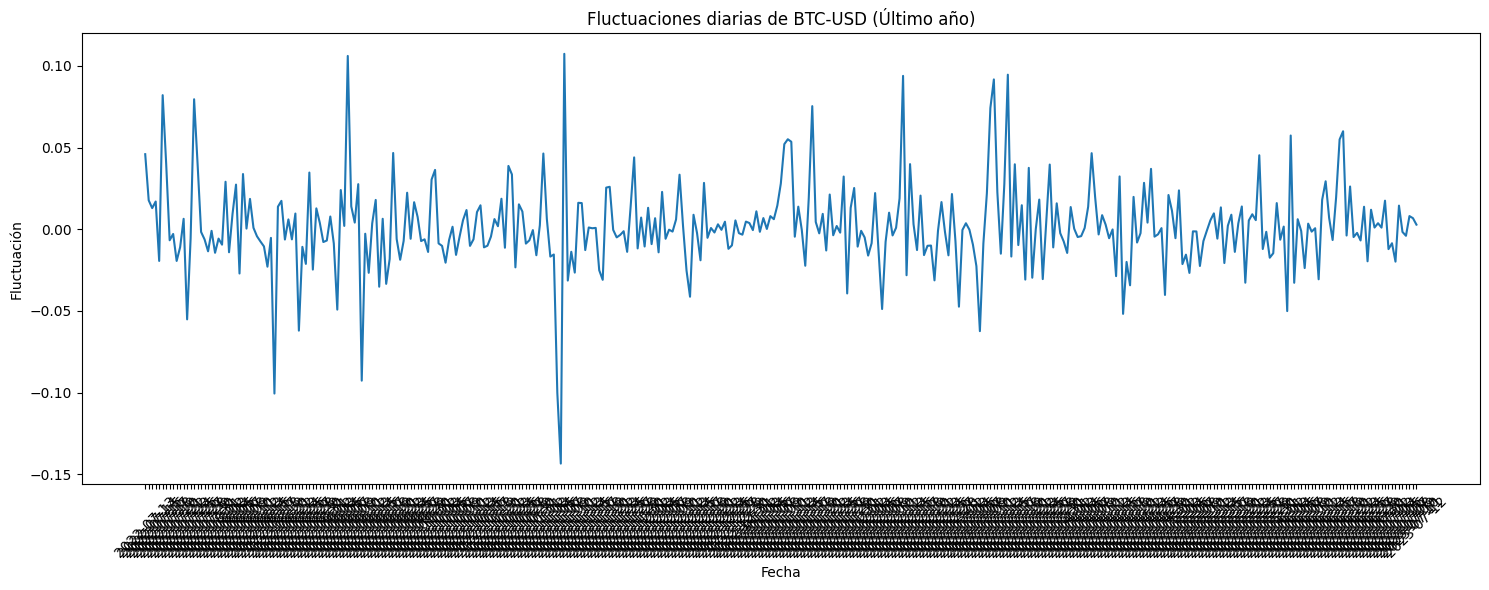

In [ ]:
# Graficar una porción de la serie temporal de BTC-USD
subset_data = data.iloc[-365:]  # Último año de datos

plt.figure(figsize=(15, 6))
plt.plot(subset_data['Date'], subset_data['BTC-USD'])
plt.title('Fluctuaciones diarias de BTC-USD (Último año)')
plt.xlabel('Fecha')
plt.ylabel('Fluctuación')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Realizar la prueba de Dickey-Fuller aumentada
p_value = adf_test(data['BTC-USD'])
p_value

0.0

Como se puede observar en el gráfico, hay un cierta volatilidad en el valor del BTC, y esto es correcto, ya que una de las carácterísticas de las criptodivisas es la volatilidad.

En cuanto a la prueba de Dickey-Fuller aumentada, el valor p obtenido es 0.0. Esto sugiere que la serie temporal de BTC-USD es estacionaria.

Con esta información, podemos proceder a identificar los parámetros óptimos para el modelo ARIMA y luego entrenar el modelo con estos parámetros.

### Identificación de parámetros para ARIMA

Se usará un enfoque simplificado utilizando el criterio de información de Akaike (AIC) para seleccionar el mejor modelo entre un rango de parámetros.

In [ ]:
#!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.3 MB/s eta 0:00:00


In [ ]:
# Usar auto_arima para encontrar los mejores parámetros
stepwise_fit = auto_arima(data['BTC-USD'], trace=True, suppress_warnings=True, stepwise=True)

# Mostrar los mejores parámetros
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-10171.234, Time=2.62 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-10175.649, Time=0.60 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-10175.142, Time=0.96 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-10175.060, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-10167.791, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-10173.950, Time=1.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 5.840 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2750
Model:                        SARIMAX   Log Likelihood                5089.824
Date:                Thu, 28 Sep 2023   AIC                         -10175.649
Time:                        17:31:11   BIC                         -10163.810
Sample:                             0   HQIC                        -10171.37

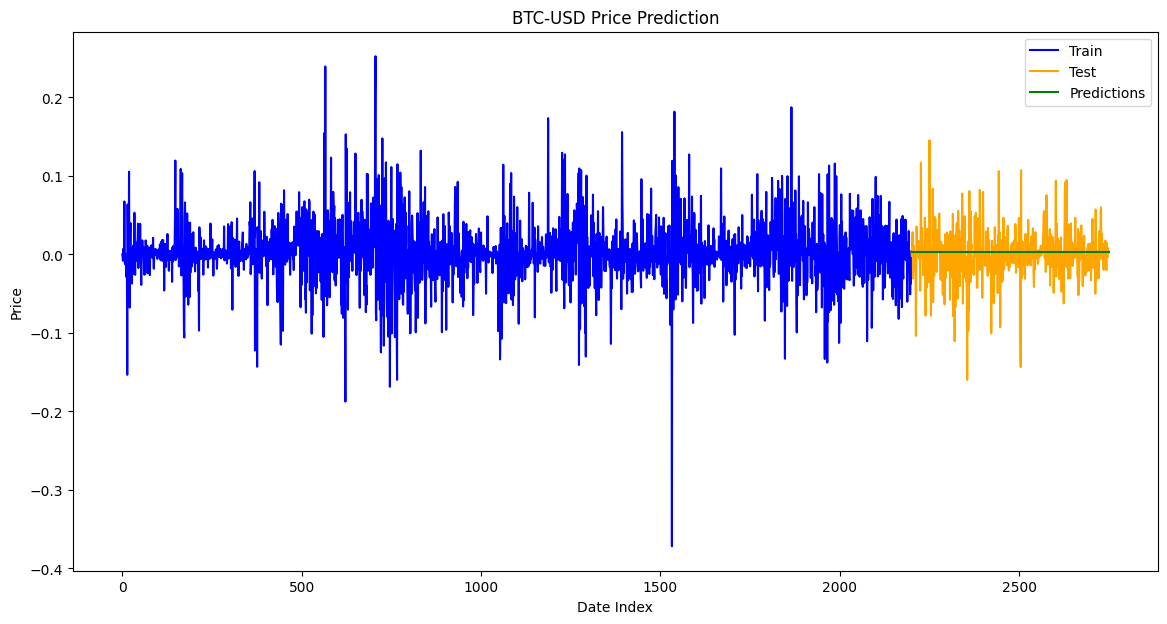

In [ ]:
# Dividir datos en entrenamiento y prueba
train_size = int(len(data) * 0.8)
train, test = data['BTC-USD'][:train_size], data['BTC-USD'][train_size:]

# Entrenar el modelo ARIMA con los datos de entrenamiento
model = ARIMA(train, order=(0,0,0))
results = model.fit()

# Predicciones
forecast = results.forecast(steps=len(test))

# Gráfica comparando valores reales con predicciones
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, forecast, label='Predictions', color='green')
plt.title('BTC-USD Price Prediction')
plt.xlabel('Date Index')
plt.ylabel('Price')
plt.legend()
plt.show()






Aunque el modelo ARIMA es una técnica popular para el análisis y predicción de series temporales. Sin embargo, tiene sus limitaciones, especialmente cuando se trata de series financieras altamente volátiles como el Bitcoin. Como se puede observar ARIMA no sirve para predecir fluctuaciones en nuestro dataset, ya que no termina de aprender y al final hace una linea constante y debería de variar, ya que el BTC es muy volátil.



# MODELO LSTM

Ahora vamos a probar con Redes Neuronales, más en específico las LSTM a ver que resultado conseguimos. Vamos a probar primero para el BTC, si se obtienen mejores resultados entonces, se usará este modelo para predecir los valores futuros.

Las redes LSTM son particularmente adecuadas para series temporales debido a su capacidad para recordar información a largo plazo. A diferencia del modelo ARIMA, las redes LSTM pueden capturar patrones más complejos y no lineales en los datos.

In [ ]:
# Normalización de los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['BTC-USD'].values.reshape(-1, 1))

# Creación de un conjunto de datos con secuencias para entrenar el modelo LSTM
window_size = 60
X, y = [], []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# División de los datos en conjuntos de entrenamiento y validación
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

De todas las configuraciones que he probado, el que mejor resultado me ha dado ha sido la siguiente arquitectura.

In [ ]:
model = Sequential()

# Capa LSTM Bidireccional
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.1))

# Segunda capa LSTM
model.add(LSTM(units=50))
model.add(Dropout(0.1))

# Capa de salida
model.add(Dense(units=1))

# Puedes considerar ajustar la tasa de aprendizaje aquí
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=40, callbacks=[early_stop])

Epoch 1/100
54/54 [==============================] - 23s 255ms/step - loss: 0.0323 - val_loss: 0.0028
Epoch 2/100
54/54 [==============================] - 7s 130ms/step - loss: 0.0058 - val_loss: 0.0026
Epoch 3/100
54/54 [==============================] - 6s 104ms/step - loss: 0.0058 - val_loss: 0.0026
Epoch 4/100
54/54 [==============================] - 7s 128ms/step - loss: 0.0055 - val_loss: 0.0026
Epoch 5/100
54/54 [==============================] - 6s 102ms/step - loss: 0.0057 - val_loss: 0.0029
Epoch 6/100
54/54 [==============================] - 7s 128ms/step - loss: 0.0054 - val_loss: 0.0025
Epoch 7/100
54/54 [==============================] - 6s 104ms/step - loss: 0.0052 - val_loss: 0.0026
Epoch 8/100
54/54 [==============================] - 7s 122ms/step - loss: 0.0052 - val_loss: 0.0025
Epoch 9/100
54/54 [==============================] - 5s 97ms/step - loss: 0.0053 - val_loss: 0.0035
Epoch 10/100
54/54 [==============================] - 6s 113ms/step - loss: 0.0054 - val_lo

17/17 [==============================] - 2s 21ms/step


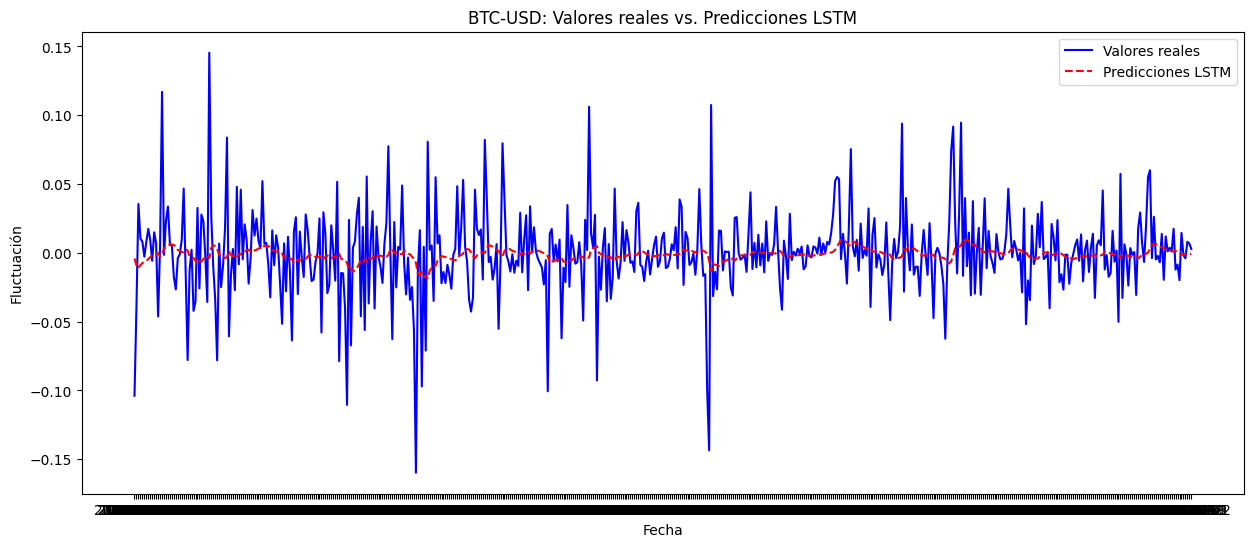

In [ ]:
# Predicciones en el conjunto de validación
predicted_values = model.predict(X_test)
predicted_values = scaler.inverse_transform(predicted_values)  # Desnormalización

# Visualización de las predicciones
plt.figure(figsize=(15, 6))
plt.plot(data['Date'][train_size+window_size:], data['BTC-USD'][train_size+window_size:], label='Valores reales', color='blue')
plt.plot(data['Date'][train_size+window_size:], predicted_values, label='Predicciones LSTM', color='red', linestyle='dashed')
plt.title('BTC-USD: Valores reales vs. Predicciones LSTM')
plt.xlabel('Fecha')
plt.ylabel('Fluctuación')
plt.legend()
plt.show()

Como se puede observar en la gráfica la red neuronal predice mejor que el modelo ARIMA, ya que aunque está lejos si los comparamos con los resultados reales, se obvserva que detecta las variaciones del BTC. Por lo que ahora se va a generar una predicción de los proximos 30 días y almacenarlos en un csv de salida.

In [ ]:
# Función para predecir fluctuaciones futuras
def predict_future_fluctuations_with_formatted_dates(inputs, model, scaler, window_size=60, future_days=30):
    predictions = []
    prediction_dates = []
    start_date = datetime.now()

    for i in range(future_days):
        X_test = np.array([inputs[-window_size:]])
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        predicted_price = model.predict(X_test)
        inputs = np.append(inputs, predicted_price)
        inputs = inputs[1:]
        predictions.append(predicted_price[0,0])
        prediction_dates.append((start_date + timedelta(days=i)).strftime('%Y-%m-%d'))

    predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
    return prediction_dates, predicted_prices

In [ ]:
for column_name in columns:
    # Escalar los datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[column_name].values.reshape(-1, 1))

    # Crear conjuntos de entrenamiento
    window_size = 60
    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Definir y entrenar el modelo LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X.shape[1], 1)))
    model.add(Dropout(0.1))
    model.add(LSTM(units=50))
    model.add(Dropout(0.1))
    model.add(Dense(units=1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    model.fit(X, y, epochs=100, batch_size=40, callbacks=[early_stop])

    # Predecir valores futuros
    predicted_dates, predicted_future = predict_future_fluctuations_with_formatted_dates(scaled_data[-window_size:].copy(), model, scaler)
    all_predictions[column_name] = predicted_future.squeeze()

Epoch 1/100
68/68 [==============================] - 13s 90ms/step - loss: 0.0384
Epoch 2/100
68/68 [==============================] - 7s 107ms/step - loss: 0.0056
Epoch 3/100
68/68 [==============================] - 6s 95ms/step - loss: 0.0054
Epoch 4/100
68/68 [==============================] - 7s 102ms/step - loss: 0.0051
Epoch 5/100
68/68 [==============================] - 8s 123ms/step - loss: 0.0051
Epoch 6/100
68/68 [==============================] - 6s 90ms/step - loss: 0.0050
Epoch 7/100
68/68 [==============================] - 7s 110ms/step - loss: 0.0051
Epoch 8/100
68/68 [==============================] - 6s 89ms/step - loss: 0.0048
Epoch 9/100
68/68 [==============================] - 7s 110ms/step - loss: 0.0049
Epoch 10/100
68/68 [==============================] - 6s 88ms/step - loss: 0.0048
Epoch 11/100
68/68 [==============================] - 7s 109ms/step - loss: 0.0050
Epoch 12/100
68/68 [==============================] - 6s 89ms/step - loss: 0.0048
Epoch 13/100
68/68

In [ ]:
# Guardar el DataFrame con las predicciones en un archivo CSV
all_predictions.insert(0, "Fecha", predicted_dates)
all_predictions.to_csv('all_future_predictions.csv', index=False)

In [ ]:
all_predictions

Fecha   BTC-USD  CNYUSD=X  EURUSD=X      GC=F
0   2023-09-28  0.003598 -0.000077 -0.000182  0.000568
1   2023-09-29  0.003662  0.000162 -0.000191  0.000612
2   2023-09-30  0.003730  0.000227 -0.000206  0.000616
3   2023-10-01  0.003787  0.000264 -0.000214  0.000616
4   2023-10-02  0.003836  0.000277 -0.000220  0.000614
5   2023-10-03  0.003878  0.000277 -0.000224  0.000611
6   2023-10-04  0.003912  0.000269 -0.000227  0.000607
7   2023-10-05  0.003942  0.000258 -0.000230  0.000603
8   2023-10-06  0.003966  0.000247 -0.000232  0.000599
9   2023-10-07  0.003986  0.000236 -0.000235  0.000596
10  2023-10-08  0.004003  0.000226 -0.000237  0.000593
11  2023-10-09  0.004017  0.000217 -0.000239  0.000590
12  2023-10-10  0.004029  0.000210 -0.000241  0.000587
13  2023-10-11  0.004038  0.000204 -0.000243  0.000585
14  2023-10-12  0.004045  0.000199 -0.000245  0.000582
15  2023-10-13  0.004052  0.000195 -0.000247  0.000580
16  2023-10-14  0.004057  0.000192 -0.000248  0.000579
17  2023-10-15  0.004061  0.000189 -0.000249  0.000577
18  2023-10-16  0.004064  0.000187 -0.000250  0.000576
19  2023-10-17  0.004067  0.000185 -0.000251  0.000575
20  2023-10-18  0.004069  0.000184 -0.000252  0.000574
21  2023-10-19  0.004071  0.000183 -0.000253  0.000573
22  2023-10-20  0.004072  0.000182 -0.000253  0.000573
23  2023-10-21  0.004074  0.000181 -0.000254  0.000572
24  2023-10-22  0.004074  0.000180 -0.000254  0.000572
25  2023-10-23  0.004075  0.000180 -0.000254  0.000571
26  2023-10-24  0.004076  0.000180 -0.000255  0.000571
27  2023-10-25  0.004076  0.000179 -0.000255  0.000571
28  2023-10-26  0.004077  0.000179 -0.000255  0.000571
29  2023-10-27  0.004077  0.000179 -0.000255  0.000570